<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-hw2/blob/main/BLM6114_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hesaplamalı Anlambilim Dersi 2.Ödevi
Konusu: Sınıflandırma

## Package installations

In [1]:
!pip install datasets torch scikit-learn transformers # uncomment if necessary

### Necessary imports

In [2]:
import torch
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

## Dataset preperations
https://huggingface.co/datasets/turkish-nlp-suite/TrGLUE

sst2 için eğitim kümesini 60K-->5K, test kümesini 9K-->1K düşürerek kullanınız.

> TrSST-2 The Stanford Sentiment Treebank is a sentiment analysis dataset includes sentences from movie reviews, annotated by human annotators. The task is to predict the sentiment of a given sentence. Our dataset is compiled from movie review websites BeyazPerde.com and Sinefil.com, both reviews and sentiment ratings are compiled from those websites. Here we offer a binary classification task to be compatible with the original GLUE task, however we offer a 10-way classification challenge in this dataset's standalone HuggingFace repo.

cola için eğitim kümesini 8K-->5K, test kümesini değiştirmeden kullanınız.

> TrCOLA The original Corpus of Linguistic Acceptability consists of sentences compiled from English literature textbooks. The task is to determine if the sentences are grammatically correct and acceptable sentences. Our corpus is also compiled from Turkish linguistic textbooks and include morphological, syntactic and semantic violations. This dataset also has a standalone repo on HuggingFace.


In [3]:
# SST2
sst2 = load_dataset("turkish-nlp-suite/TrGLUE", "sst2")
sst2_train = sst2['train'].shuffle(seed=42).select(range(5000))  # Eğitim: 60K -> 5K
sst2_test = sst2['test'].shuffle(seed=42).select(range(1000))  # Test: 9K -> 1K

# CoLA
cola = load_dataset("turkish-nlp-suite/TrGLUE", "cola")
cola_train = cola['train'].shuffle(seed=42).select(range(5000))  # Eğitim: 5K
cola_test = cola['test']  # Test: Tüm test kümesi



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Check imported data

In [4]:
sst_train_len = len(sst2_train)
sst_test_len = len(sst2_test)
cola_train_len = len(cola_train)
cola_test_len = len(cola_test)

print(f"SST2 eğitim kümesi uzunluğu: {sst_train_len}")
print(f"SST2 test kümesi uzunluğu: {sst_test_len}")
print(f"CoLA eğitim kümesi uzunluğu: {cola_train_len}")
print(f"CoLA test kümesi uzunluğu: {cola_test_len}")

# sst2_train verisinin ilk 10 satırını yazdır
print("sst2_train:")
for i in range(10):
    print(sst2_train[i])

# sst2_test verisinin ilk 10 satırını yazdır
print("\nsst2_test:")
for i in range(10):
    print(sst2_test[i])

# cola_train verisinin ilk 10 satırını yazdır
print("\ncola_train:")
for i in range(10):
    print(cola_train[i])

# cola_test verisinin ilk 10 satırını yazdır
print("\ncola_test:")
for i in range(10):
    print(cola_test[i])

SST2 eğitim kümesi uzunluğu: 5000
SST2 test kümesi uzunluğu: 1000
CoLA eğitim kümesi uzunluğu: 5000
CoLA test kümesi uzunluğu: 1000
sst2_train:
{'sentence': 'film başladığında bir müddet izlemesem mi acaba, sıkıcı bir filme benziyor diye düşündüm. Ancak ilerledikçe iyi ki devam etmişim dedim. Farklı ve gerçekten iyi bir film. İyi seyirler..', 'label': 1}
{'sentence': 'Film gerçek hayata göndermeler yapıyor. Filmi çok başarılı buldum gerçekten ender güzel yapımlardan. Her sahnesi özenle hazırlanmış. Oyunculuklar, replikler harika, fazla söze gerek yok mutlaka izlenmesi gereken bir yapım, sinema severlere duyrulur :)', 'label': 1}
{'sentence': 'harika bir animasyon. çok eğlenceli. tıpkı birincisi gibi.', 'label': 1}
{'sentence': "Ümit ünal filmlerini genelde beğenirim bu filmde keyifle izlediğim filmlerden hele ki evdeki ilk ayaküstü sorgulama sahnesi çok bizden kara mizah ama gerilimi daha çok mizahı daha az olsaydı diye de ummadım değil... Demet Evgar'ın katmanlı karakterini izlemek he

## Model installments

1. https://huggingface.co/ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1
2. https://huggingface.co/KOCDIGITAL/Kocdigital-LLM-8b-v0.1
3. https://huggingface.co/Trendyol/Llama-3-Trendyol-LLM-8b-chat-v2.0
4. https://huggingface.co/TURKCELL/Turkcell-LLM-7b-v1
5. https://huggingface.co/BrewInteractive/fikri-3.1-8B-Instruct

In [5]:
def generate_llm (model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16,
    )
    llm = pipeline("text-generation", model=model, tokenizer=tokenizer)
    return llm

# Modelleri yükleme
models = {
    "cosmos_dpo": generate_llm("ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1"),
    #"kocdigital_llm": generate_llm("KOCDIGITAL/Kocdigital-LLM-8b-v0.1"),
    #"trendyol_llm": generate_llm("Trendyol/Trendyol-LLM-8b-chat-v2.0"),
    #"turkcell_llm":generate_llm("TURKCELL/Turkcell-LLM-7b-v1"),
    "fikri_llm": generate_llm("BrewInteractive/fikri-3.1-8B-Instruct"),
}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [6]:
def build_prompts_with_examples_sst2(sentence, shot_count):
  prompt = f'Cümle: "{sentence}"\nBu cümledeki duygu olumlu mu? Lütfen sadece "Evet" veya "Hayır" şeklinde cevap verin.\n'
  selected_examples = sst2_train.shuffle(seed=42).select(range(shot_count))
  examples = ""
  for i in range(shot_count):
    cevap = ""
    if(selected_examples["label"][i] == 1):
      cevap = "Bu cümledeki duygu olumludur"
    else:
      cevap = "Bu cümledeki duygu olumsuzdur"
    examples += f'Cümle: "{selected_examples["sentence"][i]}"\nCevap: {cevap}\n'

  if (examples != ""):
    examples += "Yukarıdaki cümleleri ve cevaplarını değerlendir.\n"

  return f"{examples}{prompt}"

def build_prompts_with_examples_cola(sentence, shot_count):
  prompt = f'Cümle: "{sentence}"\nBu cümlenin Türkçe dilbilgisi kurallarına uygunluğunu değerlendirin. Eğer cümle dilbilgisi açısından kabul edilebilir ise, "Evet" değil ise "Hayır" şeklinde cevap verin.Lütfen sadece "Evet" veya "Hayır" şeklinde cevap verin.\n'
  selected_examples = cola_train.shuffle(seed=42).select(range(shot_count))
  examples = ""
  for i in range(shot_count):
    cevap = ""
    if(selected_examples["label"][i] == 1):
      cevap = "Bu cümle kurallara uygundur"
    else:
      cevap = "Bu cümle kurallara uygun değildir"
    examples += f'Cümle: "{selected_examples["sentence"][i]}"\nCevap: {cevap}\n'

  if (examples != ""):
    examples += "Yukarıdaki cümleleri ve cevaplarını değerlendir.\n"

  return f"{examples}{prompt}"


def run_prompt(prompt, model_name, max_new_tokens=150):
  print(f"Model: {model_name}")
  print(f"Prompt: {prompt}")
  outputs = models[model_name](prompt, max_new_tokens=max_new_tokens, do_sample=False)
  generated = outputs[0]['generated_text'][len(prompt):].lower().strip()
  return generated

def run_bulk_prompt(prompts, model_name, max_new_tokens=150):
  outputs = models[model_name](prompts, max_new_tokens=max_new_tokens, do_sample=False)
  generated_outputs = []
  for output in outputs:
    generated = output[0]['generated_text'][len(prompts[outputs.index(output)]):].lower().strip()  # İstem uzunluğunu çıkar
    generated_outputs.append(generated)

  return generated_outputs

def bulk_predict_for_few_shot_sst2(sentences, shot_count, model_name, batch_size=5):
  pred_labels = []
  for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i : i + batch_size] # Process sentences in batches
    prompts = [build_prompts_with_examples_sst2(sentence, shot_count) for sentence in batch_sentences]
    outputs = run_bulk_prompt(prompts, model_name)

    for i, output in enumerate(outputs):
      if "evet" in output:
        pred_labels.append(1)
      elif "hayır" in output:
        pred_labels.append(0)
      else:
        pred_labels.append(-1)

  return pred_labels

def bulk_predict_for_few_shot_cola(sentences, shot_count, model_name, batch_size=5):
  pred_labels = []
  for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i : i + batch_size] # Process sentences in batches
    prompts = [build_prompts_with_examples_cola(sentence, shot_count) for sentence in batch_sentences]
    outputs = run_bulk_prompt(prompts, model_name)

    for i, output in enumerate(outputs):
      if "evet" in output:
        pred_labels.append(1)
      elif "hayır" in output:
        pred_labels.append(0)
      else:
        pred_labels.append(-1)

  return pred_labels

In [7]:
print(sst2_test["sentence"][:5])
print(sst2_test["label"][:5])

print(sst2_test.select(range(3))["sentence"])

['Sene olmuş 2013, hala iki yaprak kıpırtısını korku filmi diye yutturmaya çalışanlar var. Efekt (ki film boyunca 1 veya 2 kez göreceksiniz) vasatın altında. Hikaye işe yaramaz, kurgu diye bir şey yok. E ne yapıyorsunuz, film çekiyoruz. Oldu!', 'İnsanın başına hiç beklemediği şeyler gelebilir gibi kısa ve klişe bir temayı filme biraz olsun anlam katmak için mi yaptılar ne...', "Etkileyici bir kişilik Desmond Doss. Kesinlikle tarihe geçen bir hikayesi var. Mel Gibson bu gibi kahramanlık hikayelerini her zaman sevmiştir. Hacksaw Ridge&te de iyi iş çıkardığını söyleyebiliriz. Aslında izlerken pek çok mantık hatası var gibi gelse de, sonradan kısaca göz attığım tarihi gerçeklerde meğer olayların büyük oranda bu şekilde gerçekleşmiş olduğunu okudum. Uzun yıllar akılda kalıcı bir film mi? Pek sanmıyorum. Çünkü nedense o Er Ryan'ı Kurtarmak gibi bir hava yok maalesef filmde. Başlangıç bölümlerini biraz daha kısaltabilirlerdi. Garfield'ın oyunculuğu başarılı ancak kendisine ödül getirmeye yete

In [8]:
print(run_prompt(build_prompts_with_examples_cola(cola_test["sentence"][0],0), "cosmos_dpo"))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Model: cosmos_dpo
Prompt: Cümle: "Eklerdeki biçim farkı, beraberinde bir anlam farkı getirmediğinden, bunlar ayrı biçimbirimler olamazlar."
Bu cümlenin Türkçe dilbilgisi kurallarına uygunluğunu değerlendirin. Eğer cümle dilbilgisi açısından kabul edilebilir ise, "Evet" değil ise "Hayır" şeklinde cevap verin.Lütfen sadece "Evet" veya "Hayır" şeklinde cevap verin.

evet.


In [9]:
print(build_prompts_with_examples_sst2(sst2_test["sentence"][0], 0))
print(build_prompts_with_examples_sst2(sst2_test["sentence"][0], 3))
print(build_prompts_with_examples_sst2(sst2_test["sentence"][0], 5))

print(build_prompts_with_examples_cola(cola_test["sentence"][0], 0))
print(build_prompts_with_examples_cola(cola_test["sentence"][0], 3))
print(build_prompts_with_examples_cola(cola_test["sentence"][0], 5))

Cümle: "Sene olmuş 2013, hala iki yaprak kıpırtısını korku filmi diye yutturmaya çalışanlar var. Efekt (ki film boyunca 1 veya 2 kez göreceksiniz) vasatın altında. Hikaye işe yaramaz, kurgu diye bir şey yok. E ne yapıyorsunuz, film çekiyoruz. Oldu!"
Bu cümledeki duygu olumlu mu? Lütfen sadece "Evet" veya "Hayır" şeklinde cevap verin.

Cümle: "en sevdiğim animelerden biri.tabii ki de ilk film olması popüleritesini de arttırdı.çok keyifli ve etkileyici sahneleri vardı.mewtwo mükemmeldi. benimde en sevdiğim pokemonlar charizard ve feraligatr"
Cevap: Bu cümledeki duygu olumludur
Cümle: "The Theory of Everything ile birlikte 2014 yapımı izlediğim en iyi biyografik film. İngiltere de bile 1967 yılına kadar eşcinselliğin suç sayılması dünya savaşları kadar insanlık ayıbıdır."
Cevap: Bu cümledeki duygu olumludur
Cümle: "1 yıldızı bile haketmiyor boşuna zaman kaybı arkadaşlar. Oyunculuk yok senaryo boş. Tek kelime ile rezalet"
Cevap: Bu cümledeki duygu olumsuzdur
Yukarıdaki cümleleri ve cevapla

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Started for 10 samples
True Labels - sst-2: [0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
True Labels - cola: [1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Model: cosmos_dpo
Shot: 0
SST-2


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

CoLA


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

Shot: 3
SST-2


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

CoLA


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

Shot: 5
SST-2


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes.

CoLA


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Model: fikri_llm
Shot: 0
SST-2


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


CoLA


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Shot: 3
SST-2


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


CoLA


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Shot: 5
SST-2


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


CoLA


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-10-59e1765c549f>:64: FutureWarning: 

The `ci` parameter is deprecated. 


Tüm sonuçlar:
         model   task  shot  accuracy        f1  precision  recall
0   cosmos_dpo  SST-2     0       0.8  0.780952   0.850000     0.8
1   cosmos_dpo   CoLA     0       0.5  0.466667   0.437500     0.5
2   cosmos_dpo  SST-2     3       0.7  0.703030   0.720000     0.7
3   cosmos_dpo   CoLA     3       0.3  0.264646   0.425000     0.3
4   cosmos_dpo  SST-2     5       0.8  0.780952   0.850000     0.8
5   cosmos_dpo   CoLA     5       0.2  0.100000   0.066667     0.2
6    fikri_llm  SST-2     0       0.4  0.350000   0.450000     0.4
7    fikri_llm   CoLA     0       0.7  0.680000   0.675000     0.7
8    fikri_llm  SST-2     3       0.5  0.505051   0.520000     0.5
9    fikri_llm   CoLA     3       0.6  0.600000   0.828571     0.6
10   fikri_llm  SST-2     5       0.4  0.400000   0.433333     0.4
11   fikri_llm   CoLA     5       0.5  0.491111   0.828571     0.5


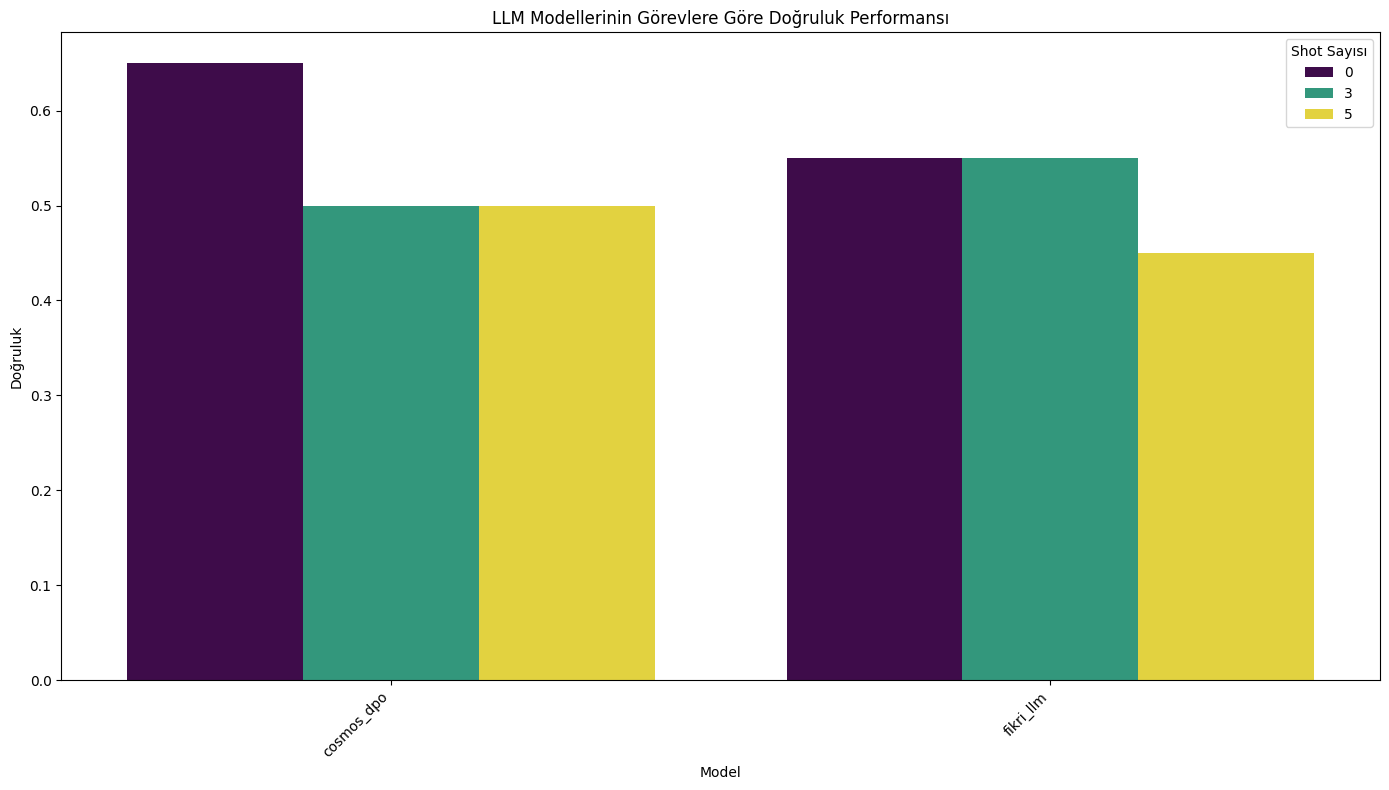

<ipython-input-10-59e1765c549f>:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='task', y='accuracy', hue='model',


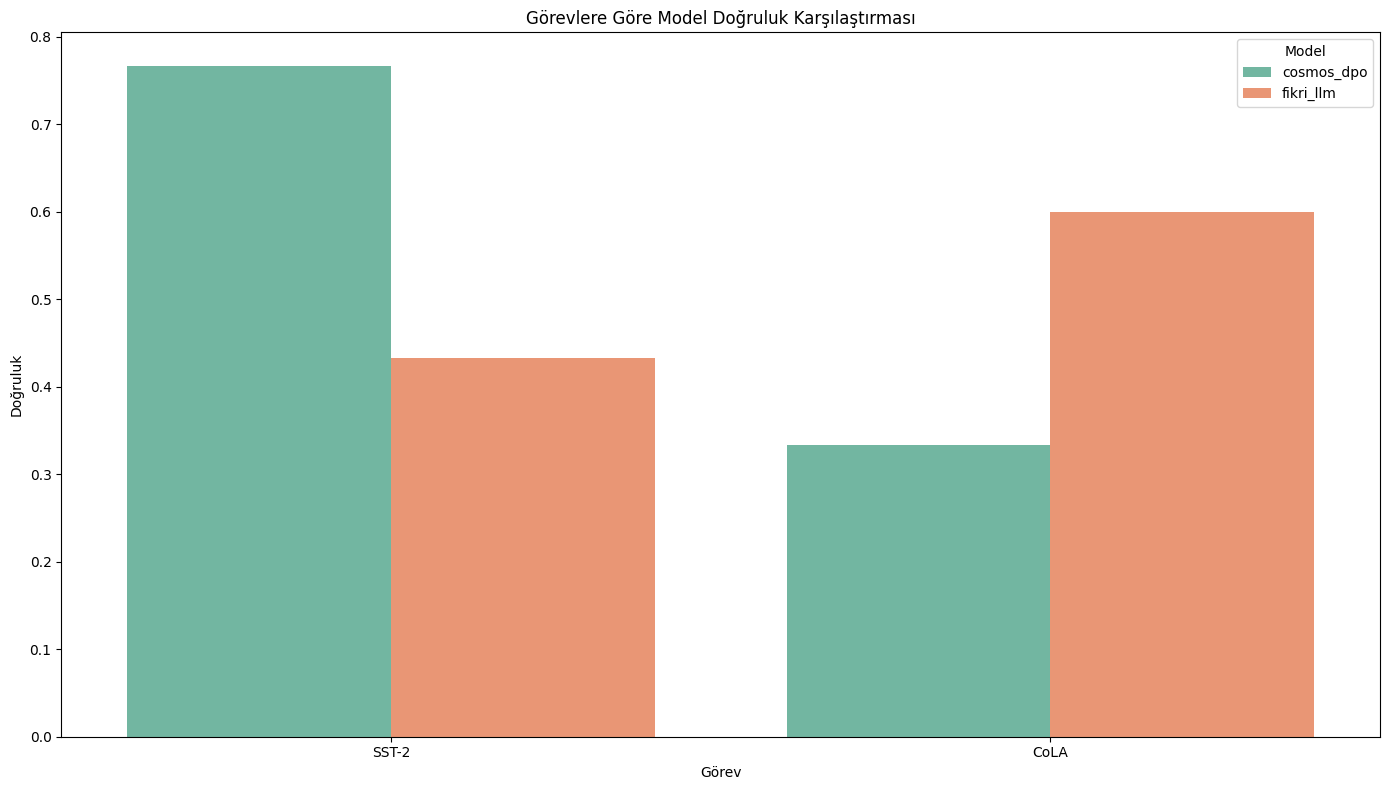

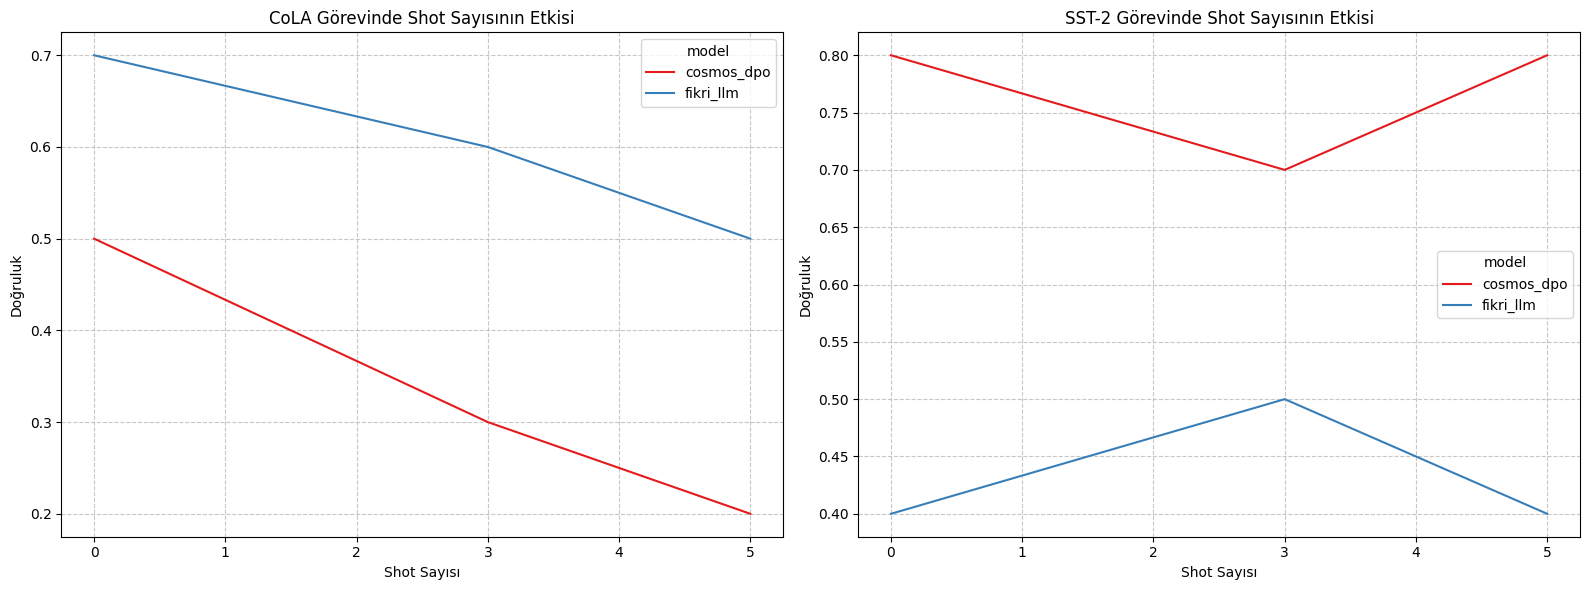


=== ÖZET RAPOR ===

CoLA görevinde en iyi performans:
Model: fikri_llm
Shot Sayısı: 0
Doğruluk: 0.7000
F1 Skor: 0.6800

SST-2 görevinde en iyi performans:
Model: cosmos_dpo
Shot Sayısı: 0
Doğruluk: 0.8000
F1 Skor: 0.7810


In [10]:
sample_count = 10
print(f"Started for {sample_count} samples")

def run_analyse_for_sst2():
  actual_labels_sst2 = sst2_test["label"][:sample_count]
  actual_labels_cola = cola_test["label"][:sample_count]
  print(f"True Labels - sst-2: {actual_labels_sst2}")
  print(f"True Labels - cola: {actual_labels_cola}")

  all_results = []

  for model in models:
    print(f"Model: {model}")

    for shot in [0, 3, 5]:
      print(f"Shot: {shot}")
      print(f"SST-2")
      predicted_labels_sst2 = bulk_predict_for_few_shot_sst2(sst2_test["sentence"][:sample_count], shot_count=shot, model_name=model)

      accuracy_sst2 = accuracy_score(actual_labels_sst2, predicted_labels_sst2)
      f1_sst2 = f1_score(actual_labels_sst2, predicted_labels_sst2, average='weighted')
      precision_sst2 = precision_score(actual_labels_sst2, predicted_labels_sst2, average='weighted')
      recall_sst2 = recall_score(actual_labels_sst2, predicted_labels_sst2, average='weighted')

      all_results.append({
        "model": model,
        "task": "SST-2",
        "shot": shot,
        "accuracy": accuracy_sst2,
        "f1": f1_sst2,
        "precision": precision_sst2,
        "recall": recall_sst2
      })

      print(f"CoLA")
      predicted_labels_cola = bulk_predict_for_few_shot_cola(cola_test["sentence"][:sample_count], shot_count=shot, model_name=model)

      accuracy_cola = accuracy_score(actual_labels_cola, predicted_labels_cola)
      f1_cola = f1_score(actual_labels_cola, predicted_labels_cola, average='weighted')
      precision_cola = precision_score(actual_labels_cola, predicted_labels_cola, average='weighted')
      recall_cola = recall_score(actual_labels_cola, predicted_labels_cola, average='weighted')

      all_results.append({
        "model": model,
        "task": "CoLA",
        "shot": shot,
        "accuracy": accuracy_cola,
        "f1": f1_cola,
        "precision": precision_cola,
        "recall": recall_cola
      })

  return all_results


results = run_analyse_for_sst2()

results_df = pd.DataFrame(results)
print("\nTüm sonuçlar:")
print(results_df)

# Görselleştirme: Task ve shot sayısına göre doğruluk
plt.figure(figsize=(14, 8))
sns.barplot(x='model', y='accuracy', hue='shot',
            data=results_df, palette='viridis',
            dodge=True, ci=None)
plt.title('LLM Modellerinin Görevlere Göre Doğruluk Performansı')
plt.xlabel('Model')
plt.ylabel('Doğruluk')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Shot Sayısı')
plt.tight_layout()
plt.savefig('model_accuracy_by_shot.png')
plt.show()

# Task ve modele göre doğruluk karşılaştırması
plt.figure(figsize=(14, 8))
sns.barplot(x='task', y='accuracy', hue='model',
            data=results_df, palette='Set2',
            dodge=True, ci=None)
plt.title('Görevlere Göre Model Doğruluk Karşılaştırması')
plt.xlabel('Görev')
plt.ylabel('Doğruluk')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('task_accuracy_by_model.png')
plt.show()

# Shot sayısının performans üzerindeki etkisi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, task in enumerate(['CoLA', 'SST-2']):
    task_df = results_df[results_df['task'] == task]
    sns.lineplot(x='shot', y='accuracy', hue='model',
                 data=task_df, palette='Set1',
                 markers=True, dashes=False, ax=axes[i])
    axes[i].set_title(f'{task} Görevinde Shot Sayısının Etkisi')
    axes[i].set_xlabel('Shot Sayısı')
    axes[i].set_ylabel('Doğruluk')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('shot_effect_on_accuracy.png')
plt.show()

# 9. Sonuçların özeti
# =============

print("\n=== ÖZET RAPOR ===")

# Görev ve model bazında en iyi performanslar
for task in ['CoLA', 'SST-2']:
    task_df = results_df[results_df['task'] == task]
    best_model_idx = task_df['accuracy'].idxmax()
    best_model = task_df.loc[best_model_idx]

    print(f"\n{task} görevinde en iyi performans:")
    print(f"Model: {best_model['model']}")
    print(f"Shot Sayısı: {best_model['shot']}")
    print(f"Doğruluk: {best_model['accuracy']:.4f}")
    print(f"F1 Skor: {best_model['f1']:.4f}")

